In [1]:
# Imports
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import u_us, u_ms, u_V
from PySpice.Unit import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import schemdraw
import schemdraw.elements as elm

In [4]:
elm.style(elm.STYLE_IEEE)
schemdraw.Drawing(font='Lato')
themes = ['solarizedd', 'solarizedl', 'onedork', 'oceans16', 'monokai', 'gruvboxl', 'gruvboxd', 'grade3', 'chesterish']
schemdraw.theme(themes[6])

In [8]:
NUM_COLS = 10
NUM_ROWS = 10

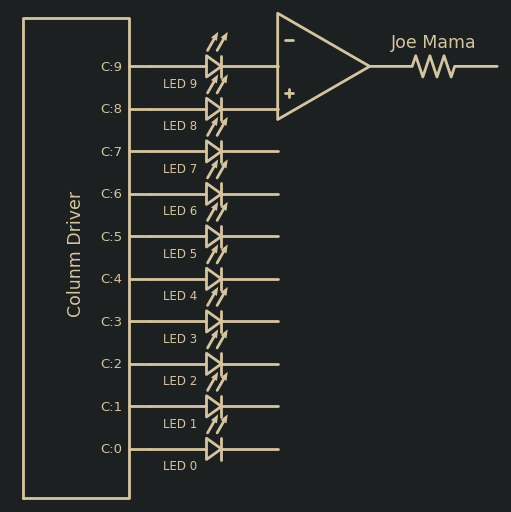

In [9]:
row_driver = elm.Ic(pins=[elm.IcPin(name=f'C:{i}', side='right', anchorname=f'c_{i}') for i in range(NUM_ROWS)],
                    edgepadW = .5,  # Make it a bit wider
                    pinspacing=1).label('Colunm Driver', rotate=90)
with schemdraw.Drawing() as d:
    d += row_driver
    for ii in range(NUM_ROWS):
        curr_column_driver_pin = getattr(row_driver, f'c_{ii}')
        new_led = elm.LED() \
                     .label(f'LED {ii}', loc='bottom', ofst=(-0.8, 0), fontsize=10) \
                     .right() \
                     .at(curr_column_driver_pin)
        try:
            next_column_driver_pin = getattr(row_driver, f'c_{ii+1}')
            d += new_led.drop(next_column_driver_pin)
        except AttributeError:
            d += new_led
    d += (opamp := elm.Opamp())
    d += elm.Resistor().right().at(opamp.out).label('Joe Mama')

# PM Design
[image](./docs/imgs/pm_array.jpg)
SRC: https://ars.els-cdn.com/content/image/1-s2.0-S0167931715300538-gr1.jpg

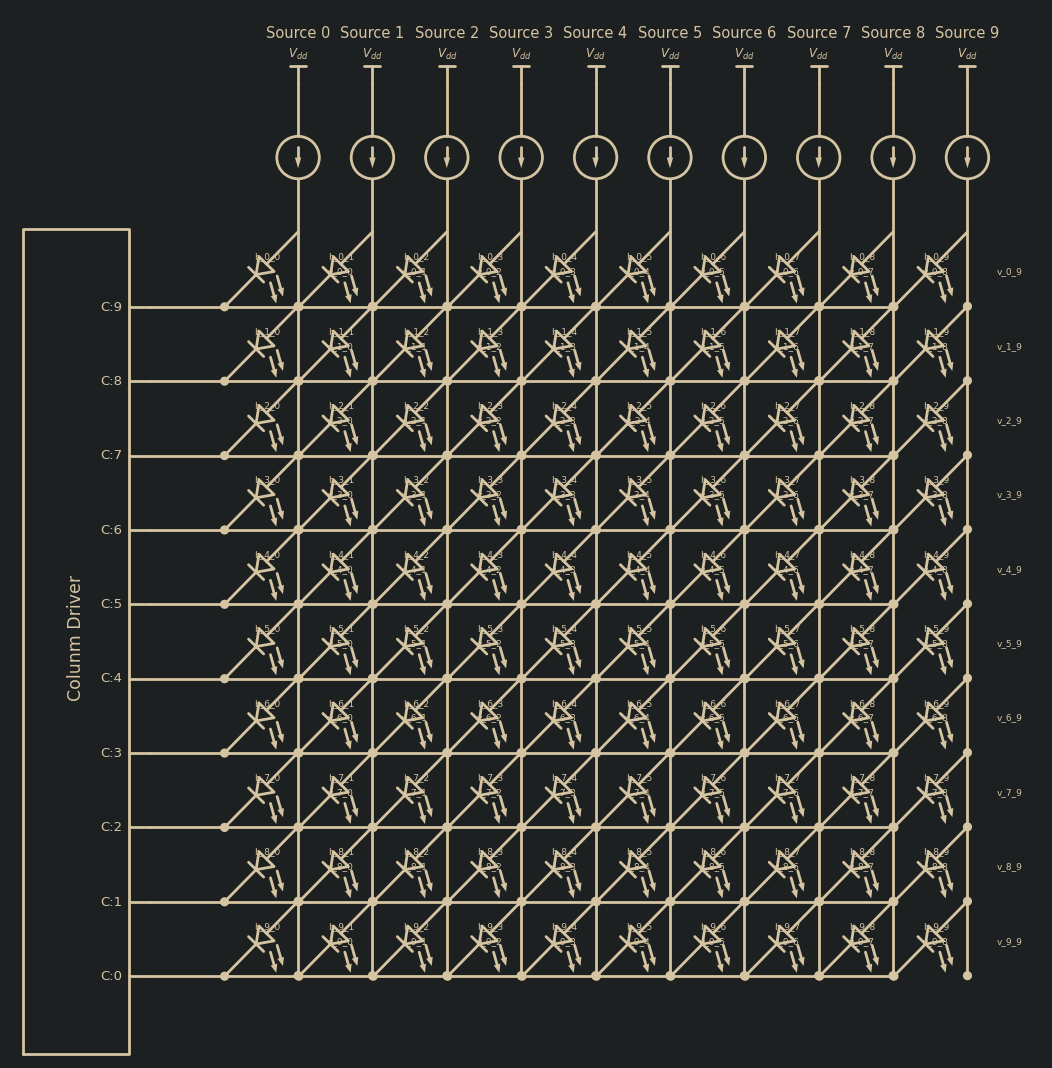

In [10]:
d = schemdraw.Drawing()
d.config(unit=3.5)
U = d.unit/2.0
row_driver = elm.Ic(pins=[elm.IcPin(name=f'C:{i}', side='right', anchorname=f'c_{i}') for i in range(NUM_ROWS)],
                    edgepadW = .5,  # Make it a bit wider
                    pinspacing=U).label('Colunm Driver', rotate=90)
d.push()
d.move(round(-3.7*U, 2), -13.05*U)
d += row_driver
d.pop()

h_positions = [ [0]*NUM_COLS for _ in range(NUM_ROWS)]
v_positions = [ [0]*NUM_COLS for _ in range(NUM_ROWS)]
for ii in range(NUM_COLS):
    # Generate Horizontal sources and wires left
    d.push()
    pin = getattr(row_driver, f'c_{ii}')
    d.move(pin.x, pin.y)
    for jj in range(NUM_ROWS):
        iii = NUM_COLS-ii-1
        d += elm.Line(anchorname=f'h_{iii}_{jj}').right().length(U)
        d += elm.Dot().label(f'h_{iii}_{jj}', fontsize=8, ofst=(1, 1))
        h_positions[iii][jj] = d.here
    d.pop()

for ii in range(NUM_COLS):
    # Generate Vertical sources and wires down
    d.push()
    d += elm.Vdd() \
            .label('$V_{dd}$',
                   fontsize=10)
    d += elm.SourceI() \
        .down() \
        .label(f'Source {ii}', 
               loc='right', 
               fontsize=12,
               ofst=(-1, 0))
    for jj in range(NUM_ROWS):
        v_positions[jj][ii] = d.here
        d += elm.Line(anchorname=f'v_{jj}_{ii}').down().length(U)
        d += elm.Dot().label(f'v_{jj}_{ii}', fontsize=8, loc='bottom', ofst=(1, 1))
    d.pop()
    d.move(U, 0)
d.draw()


for ii in range(NUM_ROWS):
    for jj in range(NUM_COLS):
        try:
            d += elm.LED().endpoints(v_positions[jj][ii  ],
                                     h_positions[jj][ii  ],)
        except IndexError:
            pass
d.draw()

In [4]:
# Define the circuit
circuit = Circuit('Diode Circuit')

In [5]:

# Add the voltage source
circuit.V('input', '+', circuit.gnd, 1@u_V)

# Add the diode
circuit.X('D1', 'D', 'input', circuit.gnd)

SubCircuitElement XD1

In [6]:
print(circuit)


.title Diode Circuit
Vinput + 0 1V
XD1 input 0 D



In [7]:
simulator = circuit.simulator(temperature=25, nominal_temperature=25)
simulator.initial_condition(input=u_V(0))


2023-04-11 04:33:17,049 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - WARNING - spinit was not found
2023-04-11 04:33:17,049 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._send_char - ERROR - Note: can't find init file.
2023-04-11 04:33:17,053 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._init_ngspice - WARNING - Unsupported Ngspice version 36


In [8]:
circuit.draw()

AttributeError: draw